In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.constants import G, k_B
from astropy.visualization import quantity_support

Matplotlib configuration

In [2]:
plt.rcParams['figure.figsize'] = [8, 3]
plt.rcParams['figure.dpi'] = 200
quantity_support()  

<astropy.visualization.units.quantity_support.<locals>.MplQuantityConverter at 0x78803b334e80>

Drop null entries of dataframe and convert to numpy array

In [3]:
def array(df):
    return df.dropna().to_numpy()

---
Mass of star $M$ ($M_\odot$)

In [4]:
M_star = 20 * u.M_sun

---
### MESA simulation data for $^{23}$Na

In [5]:
model_id = 1866
title = f"MESA model {model_id}"

In [6]:
sim = pd.read_csv(f"{int(M_star / u.M_sun)}M_models/model_{model_id}.csv")
sim

,radius,log_mass_fraction,log_T_core,radius_temp,log_Ts,radius_rho,log_rhos,log_star_age
0,0.006362,-1.909480,9.228972,-0.000036,10.197921,-0.000089,9.952260,6.989264
1,0.006527,-1.748408,NaN,0.000326,10.185615,0.000268,9.757676,NaN
2,0.006791,-1.632140,NaN,0.000452,10.131877,0.000459,9.434842,NaN
3,0.007201,-1.591433,NaN,0.000822,10.111762,0.000674,9.177563,NaN
4,0.007612,-1.584377,NaN,0.000875,10.057286,0.000576,9.638708,NaN
...,...,...,...,...,...,...,...,...
78,NaN,NaN,NaN,0.029532,8.782180,0.028688,3.789651,NaN
79,NaN,NaN,NaN,0.029927,8.765341,0.029105,3.780926,NaN
80,NaN,NaN,NaN,0.030195,8.770152,0.029516,3.818316,NaN
81,NaN,NaN,NaN,NaN,NaN,0.029960,3.756733,NaN


In [7]:
r_Z_raw   = array(sim["radius"]) * u.R_sun
Z_raw     = 10 ** array(sim["log_mass_fraction"])

r_T_raw   = array(sim["radius_temp"]) * u.R_sun
T_raw     = (10 ** array(sim["log_Ts"])) * u.K

r_rho_raw = array(sim["radius_rho"]) * u.R_sun
rho_raw   = (10 ** array(sim["log_rhos"])) * u.g / (u.cm**3)

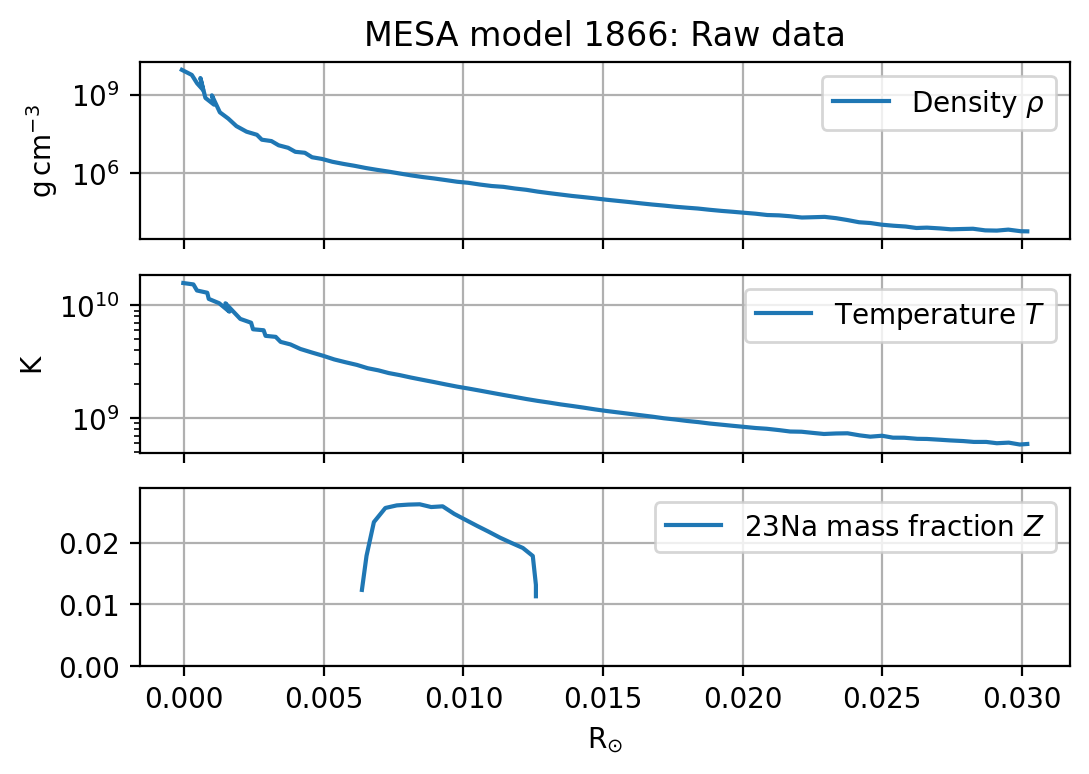

In [8]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(6, 4))
plt.sca(axs[0])
plt.yscale('log')
plt.title(f"{title}: Raw data")
plt.plot(r_rho_raw, rho_raw, label=r"Density $\rho$")

plt.sca(axs[1])
plt.yscale('log')
plt.plot(r_T_raw, T_raw, label="Temperature $T$")

plt.sca(axs[2])
plt.ylim(0, np.max(Z_raw)*1.1)
plt.plot(r_Z_raw, Z_raw, label="23Na mass fraction $Z$")

for ax in axs:
    plt.sca(ax)
    plt.legend()
    plt.grid()

plt.show()

Unified array of radii ("shells")

In [9]:
r_min = np.min(r_Z_raw.to_value(u.R_sun)) * u.R_sun
r_max = np.max(r_Z_raw.to_value(u.R_sun)) * u.R_sun
samples = int(1e5)
r = np.linspace(r_min, r_max, samples)
r

<Quantity [0.00636175, 0.00636181, 0.00636187, ..., 0.01259437, 0.01259444,
           0.0125945 ] solRad>

Shell volumes

In [10]:
dr = (r_max - r_min)/samples
dV = 4 * np.pi * r * r * dr
dV

<Quantity [3.16987854e-11, 3.16994065e-11, 3.17000277e-11, ...,
           1.24234689e-10, 1.24235919e-10, 1.24237149e-10] solRad3>

Shell temperatures, densities, and 23Na abundances, interpolated from raw MESA output

In [11]:
T = np.interp(r, r_T_raw, T_raw)
T

<Quantity [2.87254203e+09, 2.87251070e+09, 2.87247937e+09, ...,
           1.42930579e+09, 1.42929729e+09, 1.42928880e+09] K>

In [12]:
rho = np.interp(r, r_rho_raw, rho_raw)
rho

<Quantity [1640115.20505972, 1640064.55365449, 1640013.90224925, ...,
            194533.21383169,  194528.15622837,  194523.09862505] g / cm3>

In [13]:
Z = np.interp(r, r_Z_raw, Z_raw)
Z

array([0.01231744, 0.01231953, 0.01232162, ..., 0.01313377, 0.01313115,
       0.01128435])

Shell masses of $^{23}$Na

In [14]:
dM = (Z * rho * dV).to(u.g)
dM

<Quantity [2.15627161e+26, 2.15661283e+26, 2.15695403e+26, ...,
           1.06878919e+26, 1.06855916e+26, 9.18259184e+25] g>

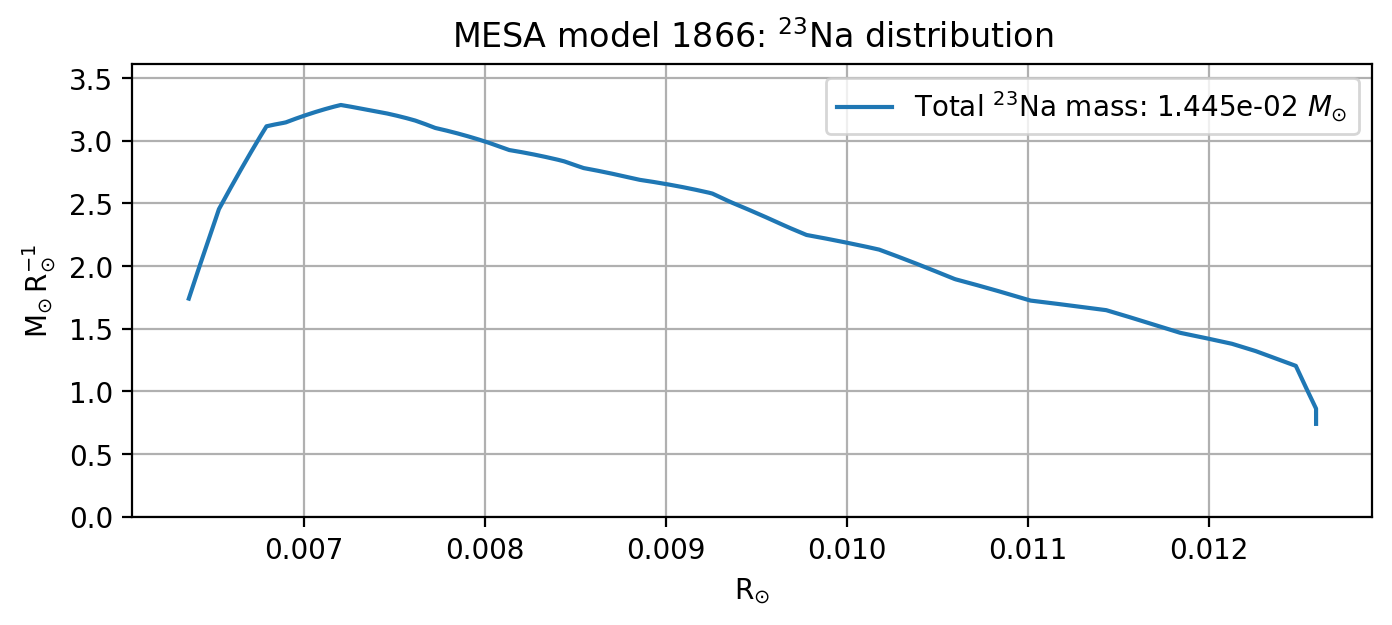

In [15]:
plt.title(f"{title}: $^{{23}}$Na distribution")
dMdr = dM.to(u.M_sun) / dr
plt.ylim(0, np.max(dMdr.value)*1.1)
plt.plot(r, dMdr, label=f"Total $^{{23}}$Na mass: {np.sum(dM).to_value(u.M_sun):.3e} $M\!_\odot$")
plt.legend()
plt.grid()

---
### Plotting parameters

Flavor-singet axial-vector matrix element $S$

In [16]:
S_range = np.linspace(-0.25, 2, 4)

Axion mass $m_a$ (eV)

In [17]:
m_a_range = np.linspace(0, 20, 40) * u.eV

---

Axion luminosity for $^{23}$Na

$\displaystyle L 
= \left[\frac{m_a}{\text{eV}}\right]^2
\times 7.2\cdot10^8\frac{\text{erg}}{\text{g}\cdot\text{s}}
\times [1 + 1.07S]^2
\times \int \frac{dM(r)}{1.5 + \exp\left(\cfrac{\beta_3}{k\cdot T(r)}\right)}
$,
$\beta_3 = 440\text{ keV}$


In [18]:
beta_3 = 440 * u.keV

In [19]:
L = lambda S, m_a: (
    ( (m_a / u.eV)**2 ) 
    * (7.2e8 * u.erg / (u.g * u.s) ) 
    * ((1 + 1.07*S)**2) 
    * np.sum(dM / (1.5 + np.exp( beta_3 / (k_B * T) )))
)

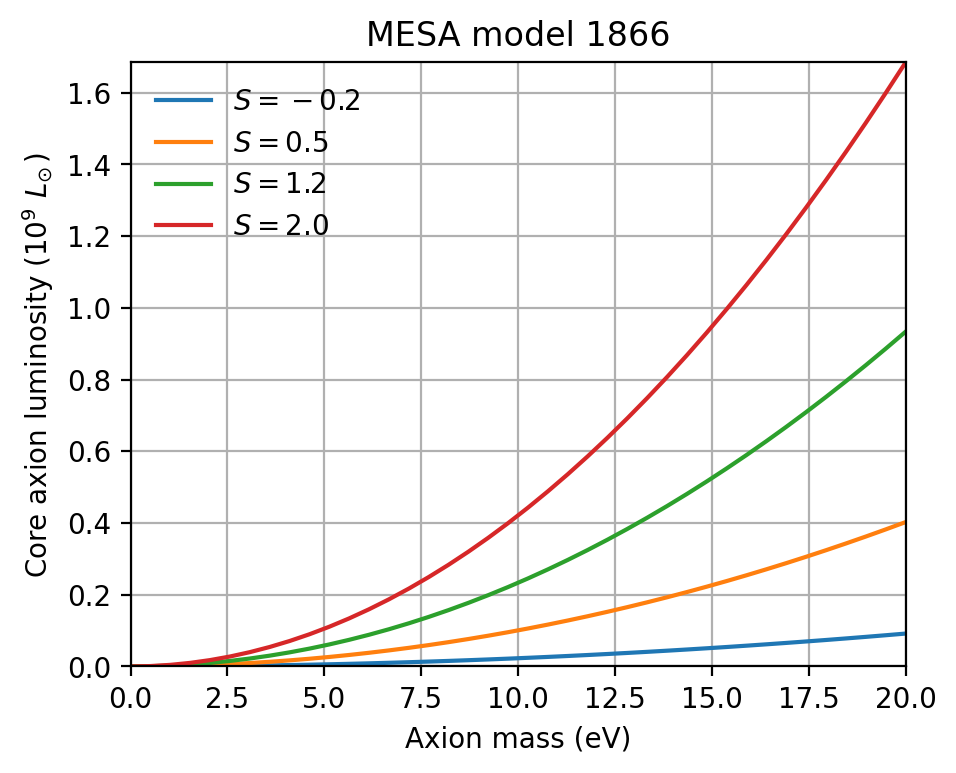

In [20]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(5, 4))
plt.sca(ax)
for (i, S) in enumerate(S_range):
    plt.plot(m_a_range.to(u.eV), L(S, m_a_range).to(1e9 * u.L_sun), label=f"$S={S:.1f}$")

plt.grid()
plt.margins(0)
plt.legend(frameon=False)
plt.xlabel("Axion mass (eV)")
plt.ylabel("Core axion luminosity ($10^9\ L\!_\odot$)")
plt.title(f"MESA model {model_id}")
plt.show()